# 1. 데이터 수집

In [1]:
import os
import requests
from random import random
from getpass import getpass

## 라벨링 된 데이터 가져오기

In [7]:
!rm -rf "./captcha_images"
!wget -q https://raw.githubusercontent.com/lstar2397/Lectures/main/Deep%20Learning/P15/Term%20Project/captcha_images.zip
!unzip -qq "./captcha_images.zip" -d "./captcha_images"
!rm "./captcha_images.zip"

# 2. 데이터 분석 및 가공

In [8]:
import cv2
import uuid
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

In [9]:
def remove_edge_border(image):
    return image.copy()[1:-1, 1:-1]

In [10]:
def threshold(image, thresh):
    image_thresh = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]
    # image_thresh = 255 * (thresh < img).astype(np.uint8)

    return image_thresh

In [11]:
def remove_whitespace(image):
    gray = 255 * (image < 128).astype(np.uint8)
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)

    return image[y:y+h, x:x+w]

In [12]:
def resize(image, width, height):
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

In [13]:
def split(image, indices):
    return np.hsplit(image, indices)

In [14]:
filenames = list(glob('./captcha_images/*.png'))
images = [cv2.imread(filename, cv2.IMREAD_GRAYSCALE) for filename in filenames]
labels = [Path(filename).stem for filename in filenames]

**캡챠 이미지 크기**

In [15]:
height, width = images[0].shape
print(f'이미지 크기: {width} x {height}')

이미지 크기: 160 x 60


**라벨 유형**

In [16]:
characters = set(char for label in labels for char in label)
max_length = max([len(label) for label in labels])
print(f'라벨 set: {", ".join(sorted(characters))}')
print(f'라벨 최대 길이: {max_length}')

라벨 set: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
라벨 최대 길이: 4


**캡챠 이미지**

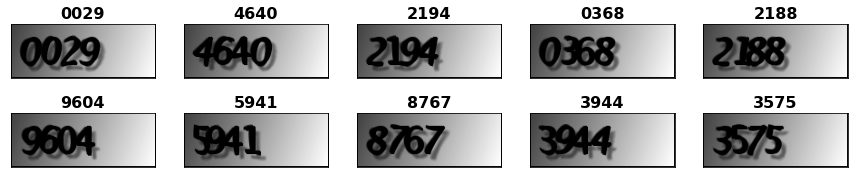

In [17]:
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(labels[i], fontdict={ 'fontsize': 16, 'fontweight': 'bold' })
    plt.xticks([])
    plt.yticks([])

In [18]:
THRESH = 40
RESIZE = 80, 30

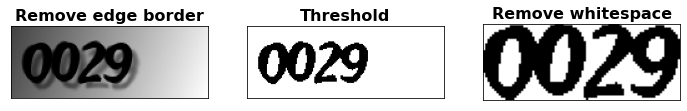

In [19]:
# 각 처리를 거쳤을 때 모습
image, label = images[0], labels[0]

border_removed_image = remove_edge_border(image)
thresholded_image = threshold(border_removed_image, THRESH)
whitespace_removed_image = remove_whitespace(thresholded_image)

preprocessing_images = [border_removed_image, thresholded_image, whitespace_removed_image]
preprocessing_titles = ["Remove edge border", "Threshold", "Remove whitespace"]

plt.figure(figsize=(12, 3))
for i in range(len(preprocessing_images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(preprocessing_images[i], 'gray')
    plt.title(preprocessing_titles[i], fontdict={ 'fontsize': 16, 'fontweight': 'bold' })
    plt.xticks([])
    plt.yticks([])

In [20]:
def save_data():
    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        border_removed_image = remove_edge_border(image)
        thresholded_image = threshold(border_removed_image, THRESH)
        whitespace_removed_image = remove_whitespace(thresholded_image)
        resized_image = resize(whitespace_removed_image, *RESIZE)
        splitted_images = split(resized_image, max_length)

        for j in range(len(splitted_images)):
            splitted_image = splitted_images[j]
            save_path = f'./data/{label[j]}'
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            
            cv2.imwrite(f'{save_path}/{uuid.uuid4()}.png', splitted_image)

In [21]:
save_data()

# 3. 딥러닝 모델 설계

In [22]:
INPUT_SHAPE = 20 * 30

# 1번째 은닉층의 노드 수
H1 = 128

# 2번째 은닉층의 노드 수
H2 = 128

# 분류 클래스의 수
NUM_CLASSES = 10

In [23]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(H1, activation='relu', input_shape=(INPUT_SHAPE,)))
    model.add(Dense(H2, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])
    
    return model

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               76928     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 94,730
Trainable params: 94,730
Non-trainable params: 0
_________________________________________________________________


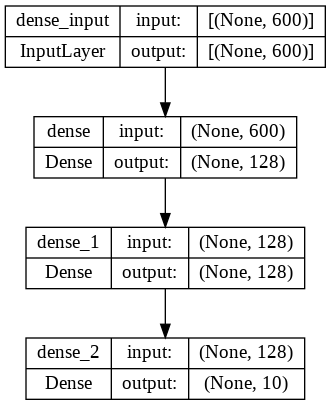

In [25]:
from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_with_shapes.png', show_shapes=True)

# 4. 딥러닝 모델 훈련 및 검증

In [26]:
from sklearn.model_selection import train_test_split

def load_data(data_dir='./data', train_size=None, test_size=None, shuffle=True):
    data, target = [], []
    
    for filename in glob(f'{data_dir}/**/*.png'):
        label = filename.split(os.path.sep)[-2]
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        data.append(image)
        target.append(label)

    data, target = np.array(data), np.array(target)
    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size, test_size=test_size, shuffle=shuffle)
    
    return (x_train, y_train), (x_test, y_test)

In [27]:
(x_train, y_train), (x_test, y_test) = load_data(train_size=0.8, test_size=0.2)
# val_size = int(len(x_train) * 0.25)
# x_val, y_val, x_train, y_train = x_train[:val_size], y_train[:val_size], x_train[val_size:], y_train[val_size:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3200, 30, 20) (3200,) (800, 30, 20) (800,)


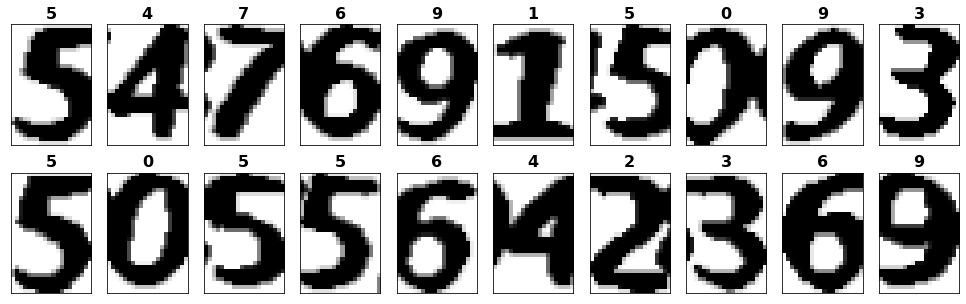

In [28]:
plt.figure(figsize=(17, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i], 'gray')
    plt.title(y_train[i], fontdict={ 'fontsize': 16, 'fontweight': 'bold' })
    plt.xticks([])
    plt.yticks([])

In [29]:
x_train = x_train.reshape(-1, INPUT_SHAPE) / 255.0
# x_val = x_val.reshape(-1, INPUT_SHAPE) / 255.0
x_test = x_test.reshape(-1, INPUT_SHAPE) / 255.0

In [30]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, NUM_CLASSES)
# y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [31]:
EPOCHS = 100
BATCH_SIZE = 64

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [33]:
history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    # validation_data=(x_val, y_val),
                    callbacks=[early_stop])

Epoch 1/100
40/40 [==============================] - 1s 10ms/step - loss: 1.8420 - accuracy: 0.5437 - val_loss: 1.4015 - val_accuracy: 0.8453
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 1.0931 - accuracy: 0.9051 - val_loss: 0.8018 - val_accuracy: 0.9453
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.6356 - accuracy: 0.9445 - val_loss: 0.4923 - val_accuracy: 0.9547
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.4162 - accuracy: 0.9555 - val_loss: 0.3428 - val_accuracy: 0.9656
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3070 - accuracy: 0.9617 - val_loss: 0.2650 - val_accuracy: 0.9719
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2444 - accuracy: 0.9680 - val_loss: 0.2160 - val_accuracy: 0.9734
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2039 - accuracy: 0.9727 - val_loss: 0.1864 - val_accuracy: 0.9750
Epoch 8/100


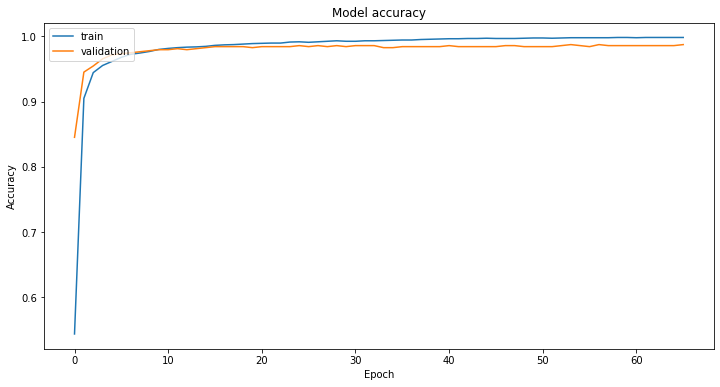

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

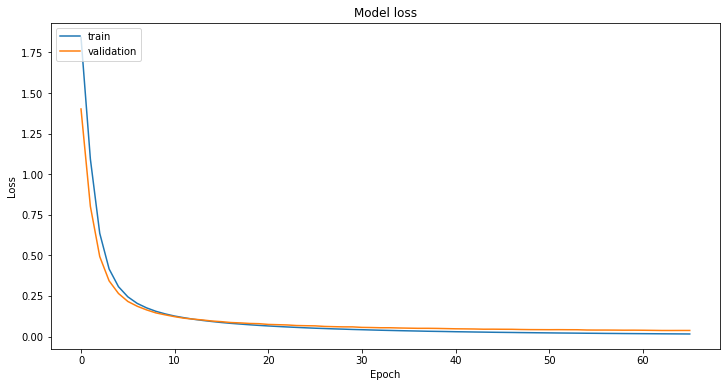

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

13/13 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9862


[0.04175436869263649, 0.9862499833106995]

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

25/25 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       0.97      0.99      0.98        84
           2       1.00      1.00      1.00        74
           3       0.97      0.99      0.98        72
           4       0.99      1.00      0.99        80
           5       0.99      0.96      0.98        84
           6       0.95      0.96      0.96        81
           7       1.00      1.00      1.00        76
           8       1.00      1.00      1.00        83
           9       1.00      0.97      0.98        90

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



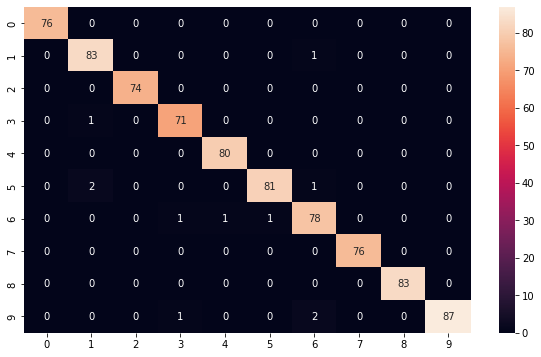

In [38]:
import seaborn as sns
plt.figure(figsize=(10, 6))
_ = sns.heatmap(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)), annot=True)

In [39]:
model.save('./model.h5')